In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import os
import sys

from micron2.clustering import Encoder, Classifier

import tensorflow as tf
import umap
import tqdm.auto as tqdm

physical_devices = tf.config.list_physical_devices('GPU')
for pdev in physical_devices:
    tf.config.experimental.set_memory_growth(pdev, True)

/home/ingn/devel/micron2/micron2/data/pull_nuclei.py:13: UserWarning: Failed to import pytiff
  warnings.warn('Failed to import pytiff')
/home/ingn/devel/micron2/micron2/data/load_nuclei.py:11: UserWarning: Failed to import pytiff.
  warnings.warn('Failed to import pytiff.')
2021-07-20 11:19:19.760796: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/ingn/devel/micron2/micron2/clustering/utils.py:18: UserWarning: Failed to import GPU tools. Accelerated neighbors/leiden/t-SNE/UMAP will not be unavailable
  warnings.warn('Failed to import GPU tools. Accelerated neighbors/leiden/t-SNE/UMAP will not be unavailable')
/home/ingn/devel/micron2/micron2/spatial/spatial_tools.py:17: UserWarning: Failed to load RAPIDS cuda-enabled tools. Falling back to sklearn
  warnings.warn("Failed to load RAPIDS cuda-enabled tools. Falling back to sklearn")
2021-07-20 11:19:21.108774: I tensorflow/stream_executor/platform/default/dso_l

In [2]:
use_channels = ['CD8', 'CD4', 'PanCytoK', 'PD-1', 'CD45', 
                'CD20', 'CD138', 'CD68', 'CD31', 'CD11c', 
                'FOXP3', 'CXCR5', 'CXCL13', 'CD3e', 
                'Ki-67', 'LAG3', 'HLA-DR', 'aSMA']

In [3]:
# Change this cell to load from multiple samples, and concatenate. 
# make sure to place channels correctly, in case they're permuted for some reason between collections.
import glob
srch = '/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/*/collection*'

image_files = sorted(glob.glob(f'{srch}/training_cells_images.npy'))
annot_files = sorted(glob.glob(f'{srch}/training_cells_annots.npy'))
channel_files = sorted(glob.glob(f'{srch}/training_cells_channels.npy'))

for f,af in zip(image_files, annot_files):
    x = np.load(f)
    y = np.load(af)
    
    if x.shape[0] != y.shape[0]:
        print(f)

for f in image_files:
    print(f)

images = np.concatenate([np.load(f) for f in image_files], axis=0)
annots = np.concatenate([np.load(f) for f in annot_files], axis=0)
channels = np.load(channel_files[0])
channels = {k:i for i,k in enumerate(channels)}

print(images.shape, images.dtype)
print(annots.shape)
print(np.unique(annots, return_counts=True))
print(channels)

# perm = np.random.choice(images.shape[0], images.shape[0], replace=False)
# images = images[perm]
# annots = annots[perm]

## subset channels
# ch_indices = [channels[ch] for ch in use_channels]
# images = images[:,:,:,ch_indices]
# print(images.shape)
# channels = {k:v for k,v in channels.items() if k in use_channels}

u_annots, annots_int = np.unique(annots, return_inverse=True)
labels = np.eye(len(u_annots))[annots_int]
labels = labels[:,1:]

print(labels.shape)
print('labelled cells:', np.sum(np.sum(labels, axis=1)>0))

/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg1/collection-21-Jul-18-19-33-17/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg2/collection-21-Jul-18-15-08-49/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg2/collection-21-Jul-18-17-33-48/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg2/collection-21-Jul-18-21-36-20/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg3/collection-21-Jul-18-16-02-55/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg3/collection-21-Jul-18-18-08-54/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210702_PembroRT_Cas19_TLSpanel_reg2/collection-21

In [4]:
# # subtract the average of each channel
# channel_means = {}
# for ch,i in channels.items():
#     stack = images[:,:,:,i]
#     mn = np.mean(stack, axis=0, keepdims=True)
#     print(ch, i, stack.shape, mn.shape)
#     channel_means[ch] = mn.copy().astype(np.float32)
    
# images_pp = images.copy().astype(np.float32)
# for ch, mn in channel_means.items():
#     if ch=='DAPI': continue
#     k = channels[ch]
#     print(ch,k,mn.shape,mn.dtype)
#     images_pp[:,:,:,k] -= mn

In [5]:
weights_path = '/home/ingn/devel/micron2/notebooks/devel_debug/moco-models/weights_cls.h5'

In [6]:
data_shape = [48, 48, len(channels)]
print(data_shape)

x_dummy = tf.zeros([1] + data_shape, dtype=tf.float32)
print(x_dummy.shape)

encoder = Encoder(data_shape=data_shape, z_dim=256, encoder_type='ResNet50V2')
z = encoder(x_dummy)

classifier = Classifier(encoder=encoder, n_classes=labels.shape[1], mlp_dim=128) 
y = classifier(x_dummy)

print(z.shape)
print(y.shape)

classifier.load_weights(weights_path)

[48, 48, 18]


2021-07-20 11:19:34.626815: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-20 11:19:34.809588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-07-20 11:19:34.809667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-20 11:19:34.810384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:21:00.0 name: GeForce 

(1, 48, 48, 18)


2021-07-20 11:19:35.800836: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-20 11:19:36.228510: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2021-07-20 11:19:36.907360: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-20 11:19:37.299730: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-20 11:19:37.339235: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(1, 256)
(1, 9)


In [7]:
def process(x):
    """
    x is [N, h, w, c]
    """
    x = tf.cast(x, tf.float32)/255.
    x = tf.image.central_crop(x, 0.75)
    
    return x
    
# Create a dataset with infinite repeating 
batch_size = 256
dataset = (tf.data.Dataset.from_tensor_slices(images)
           .map(process, num_parallel_calls=4)
           .batch(batch_size, drop_remainder=False)
           .prefetch(1)
          )

for batch in dataset:
    print(batch.shape)
    break

(256, 48, 48, 18)


2021-07-20 11:19:54.988987: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-20 11:19:55.010052: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900065000 Hz


In [8]:
preds = []
zs = []
for b in tqdm.tqdm(dataset):
    y = classifier(b, training=False)
    z = classifier.encoder(b, training=False)
    preds.append(y.numpy())
    zs.append(z.numpy())
    
preds = np.concatenate(preds, axis=0)
zs = np.concatenate(zs, axis=0)
print(preds.shape, zs.shape)

  0%|          | 0/477 [00:01<?, ?it/s]

(122092, 9) (122092, 256)


In [9]:
# help(umap.UMAP)
emb = umap.UMAP().fit_transform(zs)
print(emb.shape)

(122092, 2)


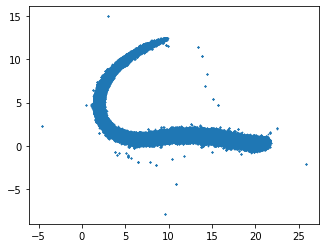

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.scatter(emb[:,0], emb[:,1], s=3, lw=0)

In [11]:
y = np.argmax(preds, axis=1)
label_map = {v:i-1 for i,v in enumerate(u_annots) if i>0}

In [12]:
np.unique(y, return_counts=True)

(array([0, 2]), array([122091,      1]))

In [13]:
has_labels = labels.sum(axis=1) > 0
np.mean(y[has_labels] == np.argmax(labels, axis=1)[has_labels])

0.186558516801854

In [14]:
np.unique(np.argmax(labels, axis=1)[has_labels], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([161, 133, 171,  14,  77, 162,  62,  65,  18]))

IndexError: index 18 is out of bounds for axis 3 with size 18

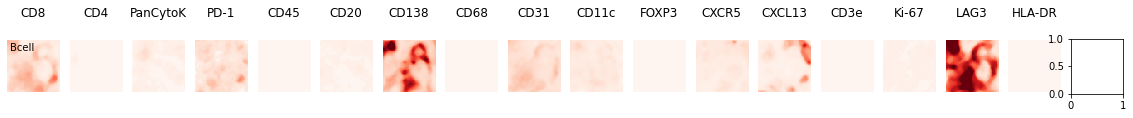

In [15]:
chs = list(channels.keys())

fig = plt.figure(figsize=(20,12))
# inds = np.random.choice(images.shape[0], 4, replace=False)

u_cts = np.unique(annots)

m = 1
for i,ct in enumerate(label_map.keys()):
    inds = np.nonzero(y==label_map[ct])[0] 
    if len(inds)==0:
        continue
    ind = np.random.choice(inds)
    
    for j,ch in enumerate(chs):
        ax = fig.add_subplot(len(u_cts),len(chs),m)
        m += 1
        
        k = channels[ch]
        img = images[ind, :, :, k] / 255.
        
        b = ax.matshow(img, cmap='Reds', vmin=0, vmax=1)
        # plt.colorbar(b, ax=ax)
        ax.axis('off')
    
        if i==0:
            ax.set_title(ch)
        
        if j==0:
            ax.annotate(ct, (0.05, 0.8), xycoords='axes fraction', color='k')